# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import sp_data_util as spdata
from sp_data_util import sp_plot
import itertools as itertx

First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,5.984642,4.294619,14.810233,16.446558,13.379920,12.797028,A2,B1,C3
1,11.830086,8.479432,15.539068,15.406967,9.592075,8.939419,A1,B1,C1
2,6.599455,10.893792,10.796894,4.603648,10.356362,9.304940,A0,B0,C1
3,7.337738,3.038439,15.576636,15.323683,10.872977,9.536993,A2,B1,C1
4,12.301366,7.154831,8.110618,6.032369,8.736354,8.574557,A1,B0,C1


We'll also plot them in the dimensions where we added SP

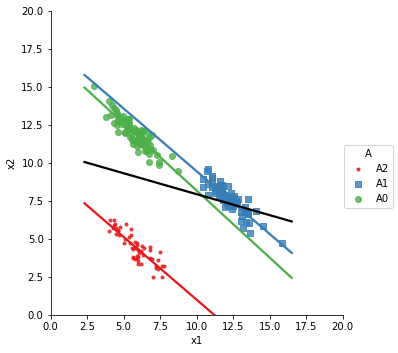

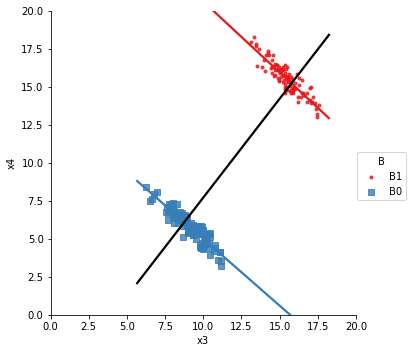

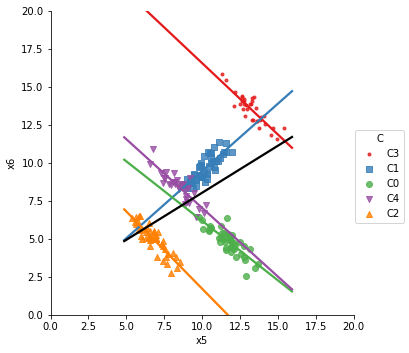

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.081016,x1,x4,-0.010056,A,A0,False
1,-0.091381,x1,x5,0.004374,A,A0,False
2,-0.050521,x2,x4,0.066268,A,A0,False
3,0.006240,x2,x5,-0.075937,A,A0,False
4,-0.091381,x1,x5,0.101171,A,A1,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    47
True      6
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

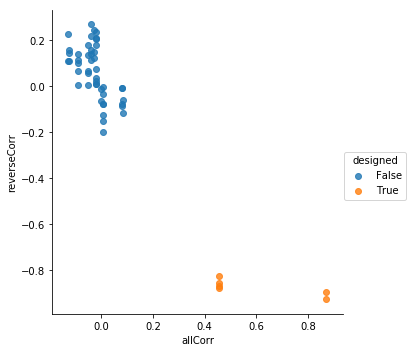

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,47.0,-0.027617,0.057930,-0.127231,-0.050521,-0.022382,0.00624,0.083792
True,6.0,0.593756,0.215937,0.454369,0.454369,0.454369,0.76799,0.872530


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module so and these will all add columns.  

In [8]:
results_df_slopes = dsp.add_slope_sp(many_sp_df_diff, many_sp_df_diff_result)
all_slopes_df = dsp.compute_slope_all(many_sp_df_diff, ['x' +str(i+1) for i in range(n_views*2)])
results_df_slopes = results_df_slopes.merge(all_slopes_df, left_on=['attr1','attr2'], right_on=['attr1','attr2'])
results_df_slopes['angle'] = results_df_slopes.apply(dsp.compute_angle,axis=1)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.081016,x1,x4,-0.010056,A,A0,False,-0.048807,0.126881,10.025336
1,0.081016,x1,x4,-0.087875,A,A2,False,-0.441596,0.126881,31.057180
2,0.081016,x1,x4,-0.077650,B,B0,False,-0.026760,0.126881,8.763969
3,0.081016,x1,x4,-0.010134,B,B1,False,-0.003129,0.126881,7.410367
4,-0.091381,x1,x5,0.004374,A,A0,False,0.010721,-0.069287,-4.577729


In [16]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
38,0.872530,x3,x4,-0.894307,B,B1,True,-0.932578,1.300153,95.436598
37,0.872530,x3,x4,-0.923568,B,B0,True,-0.878615,1.300153,93.737696
50,0.454369,x5,x6,-0.876218,C,C2,True,-1.015945,0.618764,77.200900
51,0.454369,x5,x6,-0.866199,C,C3,True,-0.939437,0.618764,74.959137
52,0.454369,x5,x6,-0.856584,C,C4,True,-0.903801,0.618764,73.855054
49,0.454369,x5,x6,-0.825148,C,C0,True,-0.782778,0.618764,69.800779
1,0.081016,x1,x4,-0.087875,A,A2,False,-0.441596,0.126881,31.057180
29,0.083792,x1,x3,-0.115545,A,A2,False,-0.367151,0.088068,25.193666
16,0.006240,x2,x5,-0.151231,A,A2,False,-0.352205,0.004695,19.671537
14,0.006240,x2,x5,-0.075937,A,A0,False,-0.188049,0.004695,10.919056


In [31]:
results_df_slopes.sort_values('allCorr',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
38,0.872530,x3,x4,-0.894307,B,B1,True,-0.932578,1.300153,95.436598
37,0.872530,x3,x4,-0.923568,B,B0,True,-0.878615,1.300153,93.737696
52,0.454369,x5,x6,-0.856584,C,C4,True,-0.903801,0.618764,73.855054
51,0.454369,x5,x6,-0.866199,C,C3,True,-0.939437,0.618764,74.959137
50,0.454369,x5,x6,-0.876218,C,C2,True,-1.015945,0.618764,77.200900
49,0.454369,x5,x6,-0.825148,C,C0,True,-0.782778,0.618764,69.800779
30,0.083792,x1,x3,-0.058467,B,B1,False,-0.017310,0.088068,6.024593
29,0.083792,x1,x3,-0.115545,A,A2,False,-0.367151,0.088068,25.193666
1,0.081016,x1,x4,-0.087875,A,A2,False,-0.441596,0.126881,31.057180
0,0.081016,x1,x4,-0.010056,A,A0,False,-0.048807,0.126881,10.025336


In [34]:
results_df_slopes.sort_values('angle', ascending=False).rank(numeric_only=True).head(10)

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
38,52.5,2.0,50.5,3.0,52.5,53.0
37,52.5,1.0,50.5,5.0,52.5,52.0
50,49.5,3.0,50.5,1.0,49.5,51.0
51,49.5,4.0,50.5,2.0,49.5,50.0
52,49.5,5.0,50.5,4.0,49.5,49.0
49,49.5,6.0,50.5,6.0,49.5,48.0
1,43.5,11.0,24.0,7.0,45.5,47.0
29,46.5,10.0,24.0,8.0,42.5,46.0
16,38.0,8.0,24.0,9.0,38.0,45.0
14,38.0,14.0,24.0,10.0,38.0,44.0


We can look at the spearman correlation of the various features.  THis is equic

In [26]:
results_df_slopes.corr(method='spearman')

,allCorr,reverseCorr,designed,subgroup_slope,all_slope,angle
allCorr,1.000000,-0.750779,0.550973,-0.777651,0.946460,0.875666
reverseCorr,-0.750779,1.000000,-0.548892,0.868973,-0.721318,-0.803177
designed,0.550973,-0.548892,1.000000,-0.548892,0.550973,0.548892
subgroup_slope,-0.777651,0.868973,-0.548892,1.000000,-0.798047,-0.953153
all_slope,0.946460,-0.721318,0.550973,-0.798047,1.000000,0.907313
angle,0.875666,-0.803177,0.548892,-0.953153,0.907313,1.000000


In [10]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,47.0,-4.762192,13.692064,-39.592347,-8.344660,-4.388099,1.682488,31.057180
True,6.0,80.831694,10.935193,69.800779,74.131075,76.080018,89.603497,95.436598


In [13]:
results_df_slopes.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,47.0,-0.027617,0.057930,-0.127231,-0.050521,-0.022382,0.00624,0.083792
True,6.0,0.593756,0.215937,0.454369,0.454369,0.454369,0.76799,0.872530


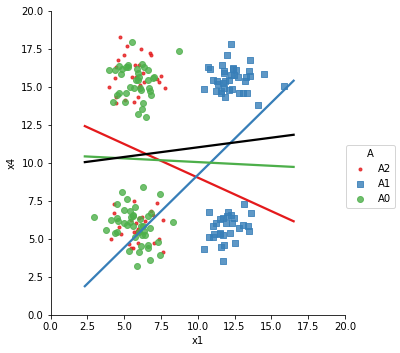

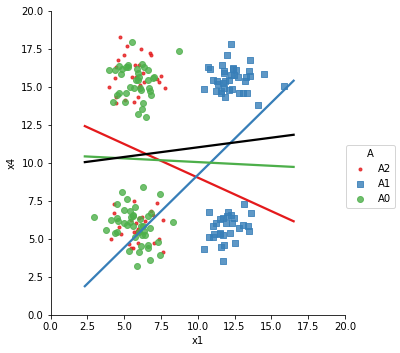

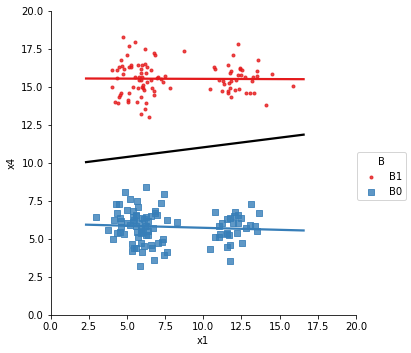

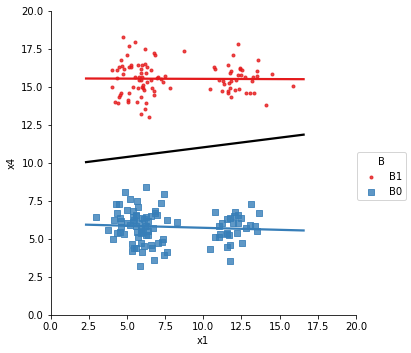

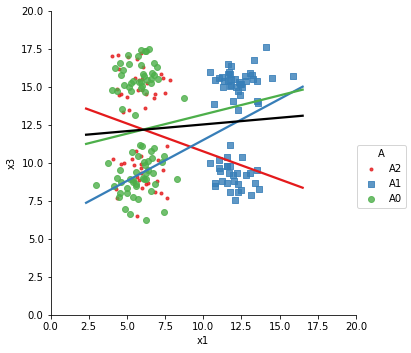

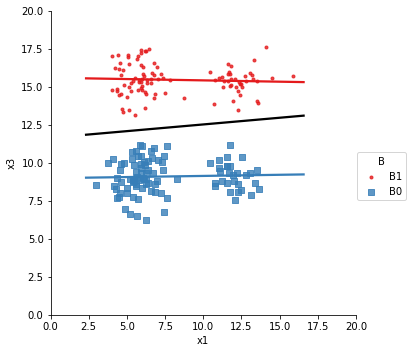

In [11]:

for row in results_df_slopes[['allCorr','attr1','attr2','groupbyAttr','designed']].values:
    if not row[4] and row[0] >.08:
        sp_plot(many_sp_df_diff,row[1],row[2],row[3])

In [12]:
many_sp_df_diff.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'A', 'B', 'C'], dtype='object')

Another way we might want to examine the subgroups is to see if the errors to the whole data set model orelate with class.  Ths is if the errors are hihgly deparable, thn 